Team members:
Xi Li
Yulei Sun
Hsiao Yuan Wang
Hongming Zhang

## Data Model

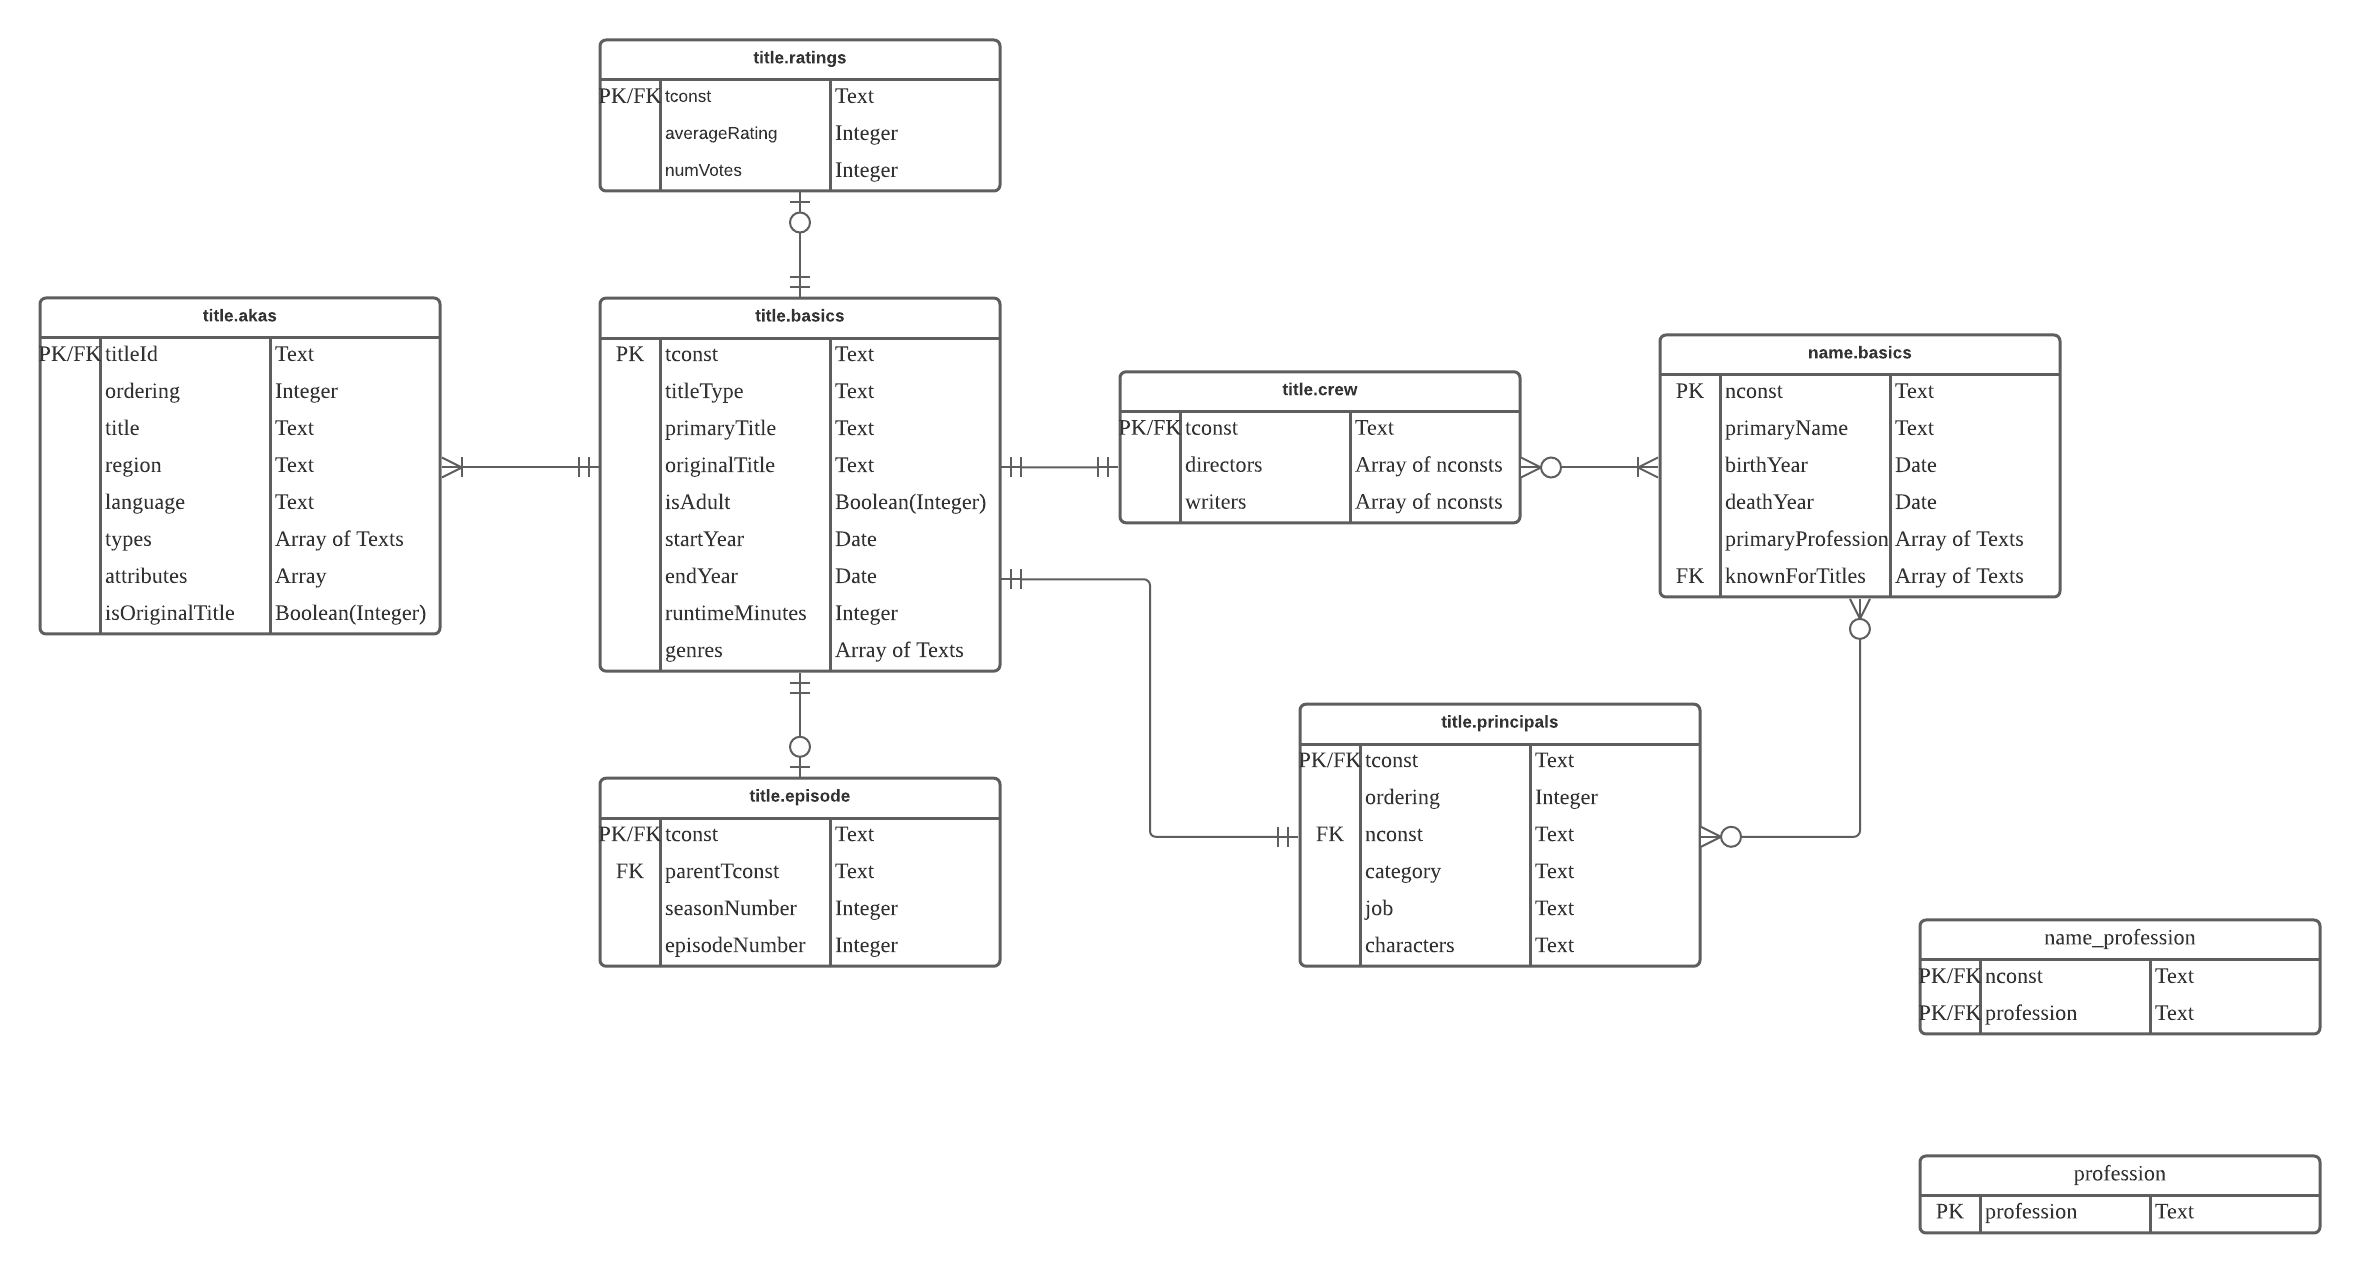

In [1]:
"""
2A: ERD of the original data
"""
from IPython.display import Image
Image("ERD.png")

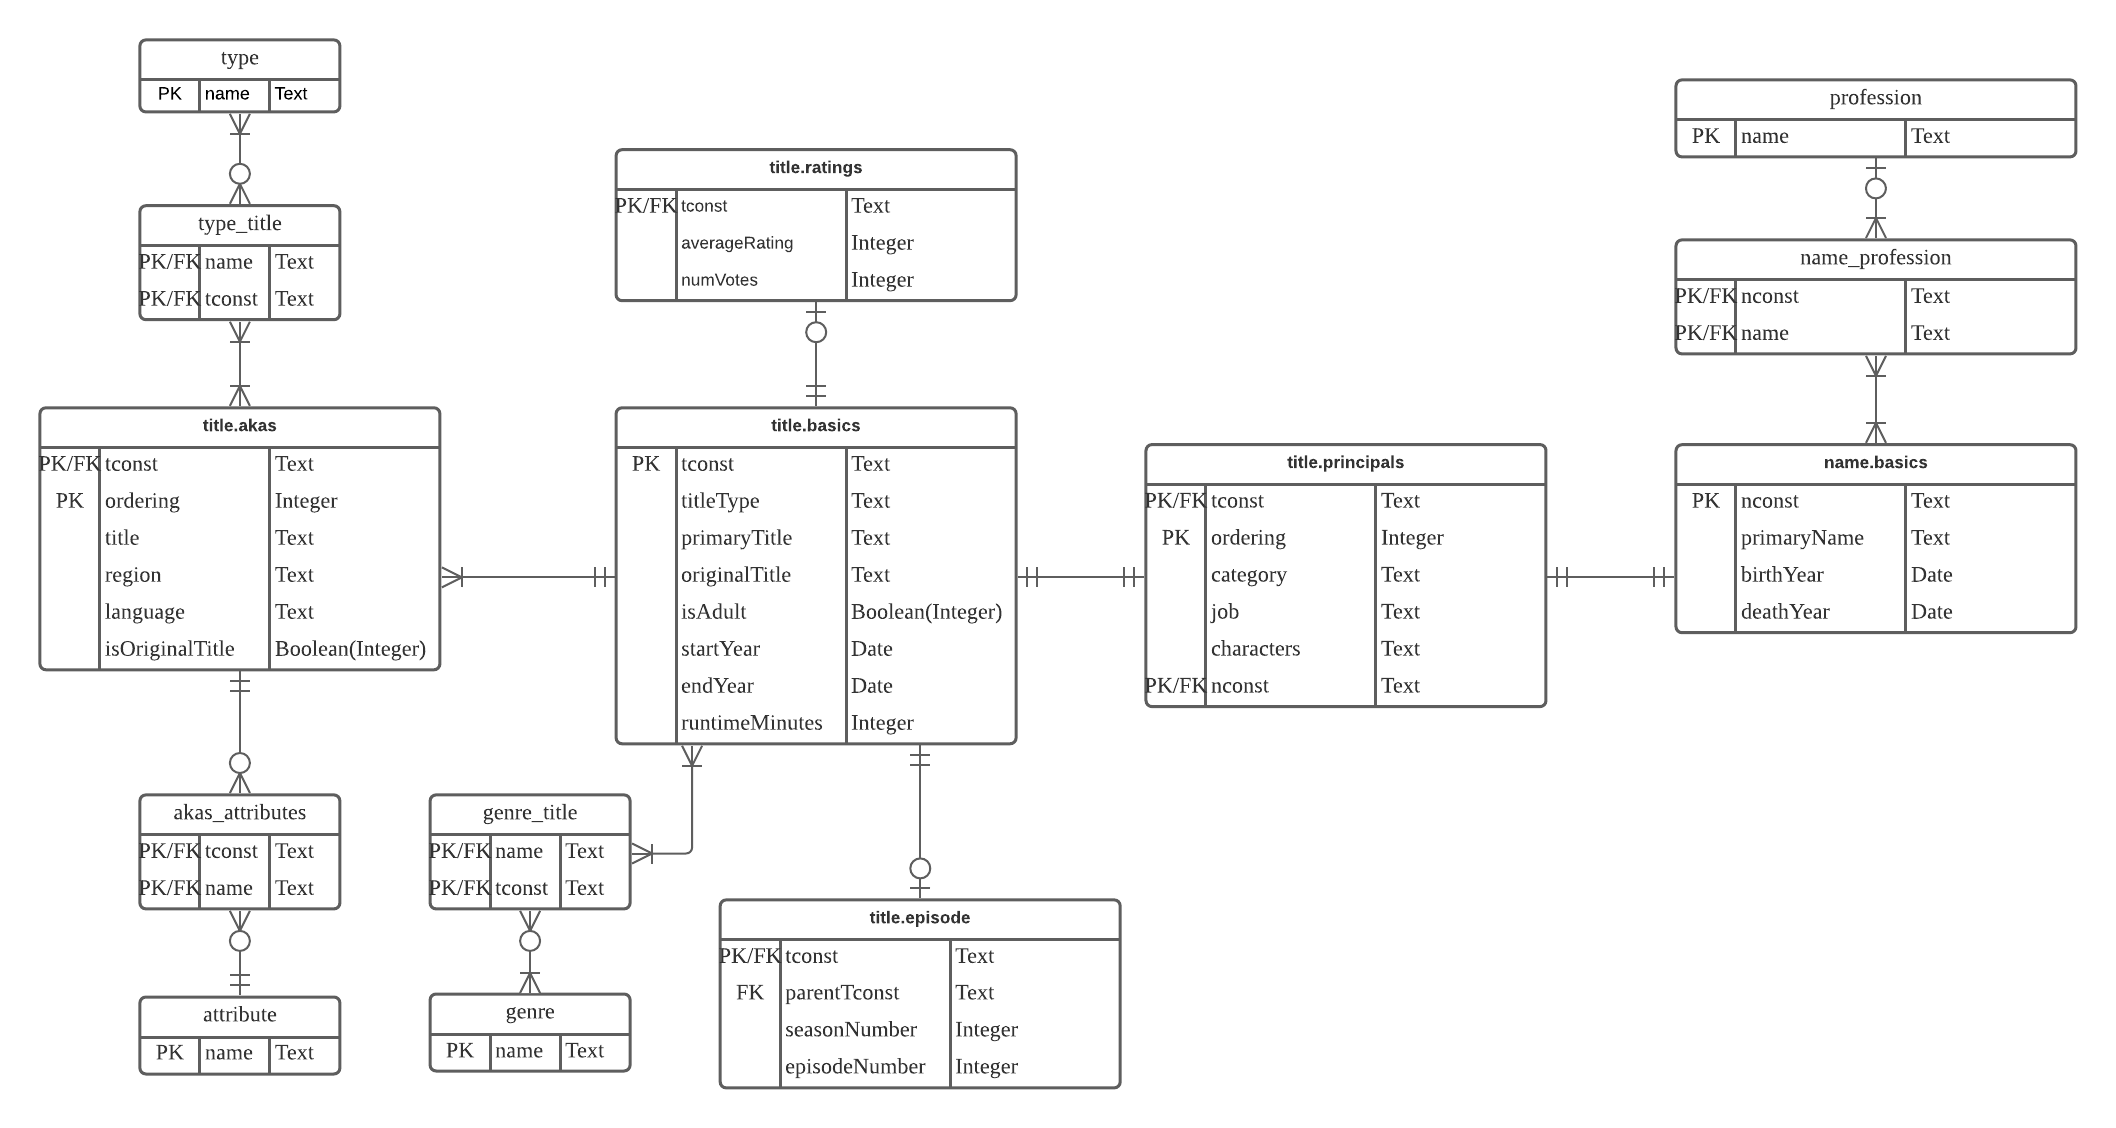

In [2]:
"""
2B: ERD after normalizing to BCNF
"""
Image("ERD_normalized.png")

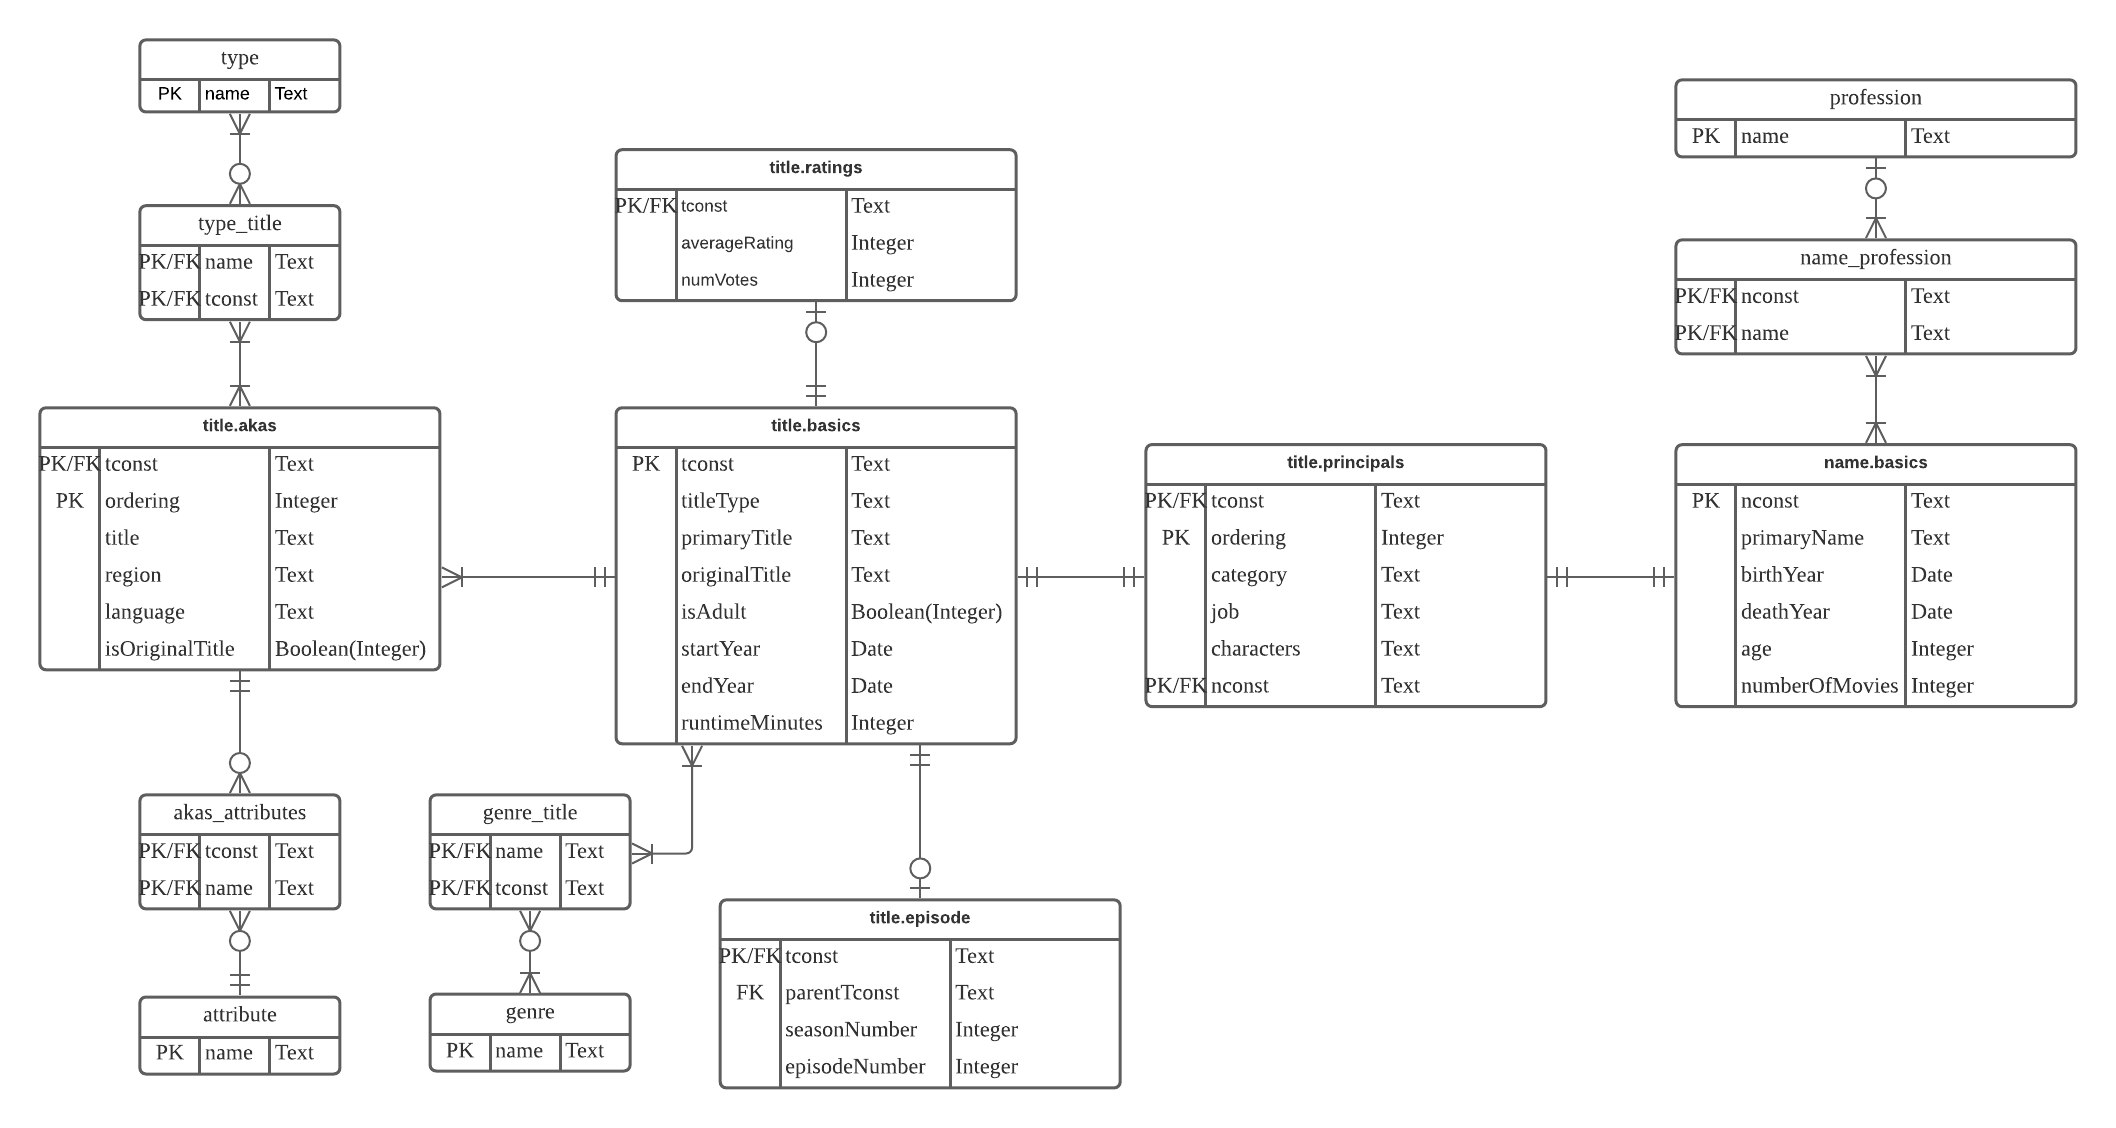

In [3]:
"""
2C: ERD after adding age and numberOfMovies attributes
"""
Image("2CD.png")

2C: Why would someone choose to denormalize data as done in 2C?

We denormalized the newly added "age" and "numberOfMovies" attributes in 2C because it increases performance of our database.
These two attributes are closely related to each row of the table "name.basics" since they are part of the information of each person. Thus, denormalizing them increases the read performance when we want to fetch information related to each person, because we no longer need to join multiple tables (internally running loops) just to figure out the age of a given person. Moreover, it also reduces the complexity of such operations, because it's more natural for database users to think that a person's age and number of movie appearances should be stored on the same row of that person.

## Import Data and Data Parsing

In [4]:
import pandas as pd

"""
Import Data
"""
title_akas_data = pd.read_csv('title.akas.tsv', sep = '\t', nrows = 50000)
title_basic_data = pd.read_csv('title.basics.tsv', sep = '\t', nrows = 50000)
title_ratings_data = pd.read_csv('title.ratings.tsv', sep = '\t', nrows = 50000)
title_episode_data = pd.read_csv('title.episode.tsv', sep = '\t', nrows = 50000)
title_principals_data = pd.read_csv('title.principals.tsv', sep = '\t', nrows = 50000)
name_basics_data = pd.read_csv('name.basics.tsv', sep = '\t', nrows = 50000)
title_crew_data = pd.read_csv('title.crew.tsv', sep = '\t', nrows = 50000)

"""
Data Parsing
"""
# parse type data
type_data_set = set(title_akas_data['types'])
type_data = pd.DataFrame(list(type_data_set), columns = ['name'])

# parse attribute data
attribute_data_set = set(title_akas_data['attributes'])
attribute_data = pd.DataFrame(list(attribute_data_set), columns = ['name'])


# parse genre data
genre_data_raw = title_basic_data['genres']
genre_data_set = set()
for data in genre_data_raw:
    data = str(data).split(",")
    for item in data:
        if item:
            genre_data_set.add(item)
genre_data = pd.DataFrame(list(genre_data_set), columns = ['name'])

# parse title_basic data
title_basics = pd.DataFrame(title_basic_data, columns=['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes'])


# parse title_aka data
title_akas = pd.DataFrame(title_akas_data, columns=['titleId', 'ordering', 'title', 'region', 'language', 'isOriginalTitle'])

# parse title_ratings data
title_ratings = pd.DataFrame(title_ratings_data, columns=['tconst', 'averageRating', 'numVotes'])

# parse title_episode data
title_episode = pd.DataFrame(title_episode_data, columns=['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber'])

# parse title_principals data
title_principals = pd.DataFrame(title_principals_data, columns=['tconst', 'ordering', 'category', 'job', 'characters', 'nconst'])

# parse name_basics data
name_basics = pd.DataFrame(name_basics_data, columns=['nconst', 'primaryName', 'birthYear', 'deathYear'])

# parse profession data
profession_data_raw = name_basics_data['primaryProfession']
profession_data_set = set()
for data in profession_data_raw:
    data = str(data).split(",")
    for item in data:
        if item:
            profession_data_set.add(item)
profession_data = pd.DataFrame(list(profession_data_set), columns = ['name'])

# parse type_title data
type_aka_data = pd.DataFrame(title_akas_data, columns=['types', 'titleId']).drop_duplicates()

# parse akas_attribute data
akas_attributes = pd.DataFrame(title_akas_data, columns=['titleId', 'attributes']).drop_duplicates()

# parse genre_title data
genre_title = pd.DataFrame(title_basic_data, columns=['tconst', 'genres']).drop_duplicates()

# parse name_profession data
name_profession = pd.DataFrame(name_basics_data, columns=['nconst', 'primaryProfession']).drop_duplicates()

## Create Table

In [5]:
import sqlite3

""""
Connect with database
"""
con_db = sqlite3.connect('mydb.db')

"""
Create Tables
"""

# Create type table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS type
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS type (
            "name" varchar(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# Create attribute table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS attribute
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS attribute(
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create type_title table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS type_title
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS type_title (
            name VARCHAR(255) NOT NULL,
            tconst VARCHAR(255) NOT NULL,
            PRIMARY KEY (name, tconst),
            FOREIGN KEY (name) REFERENCES type(name),
            FOREIGN KEY (tconst) REFERENCES title_akas(tconst)
            );
            ''')
con.close()

# create title_akas table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS title_akas
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS title_akas(
            tconst VARCHAR(255),
            ordering INT,
            title VARCHAR(255),
            region VARCHAR(255),
            language VARCHAR(255),
            isOriginalTitle INT,
            PRIMARY KEY (tconst, ordering),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create akas_attributes table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS akas_attributes
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS akas_attributes(
            tconst VARCHAR(255),
            name VARCHAR(255),
            PRIMARY KEY (tconst, name),
            FOREIGN KEY (tconst) REFERENCES title_akas(tconst),
            FOREIGN KEY (name) REFERENCES attribute(name)
            );
            ''')
con.close()

# create title_ratings table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS title_ratings
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS title_ratings (
            tconst VARCHAR(255),
            averageRating INT,
            numVotes INT,
            PRIMARY KEY (tconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_basics table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS title_basics
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS title_basics (
            tconst VARCHAR(255),
            titleType VARCHAR(255),
            primaryTitle VARCHAR(255),
            originalTitle VARCHAR(255),
            isAdult INT,
            startYear VARCHAR(255),
            endYear VARCHAR(255),
            runtimeMinutes INT,
            PRIMARY KEY (tconst)
            );
            ''')
con.close()

# create genre_title table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS genre_title
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS genre_title (
            name VARCHAR(255),
            tconst VARCHAR(255),
            PRIMARY KEY (name, tconst),
            FOREIGN KEY (name) REFERENCES genre(name),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_episode table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS title_episode
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS title_episode(
            tconst VARCHAR(255),
            parentTconst VARCHAR(255),
            seasonNumber INT,
            episodeNumber INT,
            PRIMARY KEY (tconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (parentTconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_principals table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS title_principals
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS title_principals (
            tconst VARCHAR(255),
            ordering INT,
            category VARCHAR(255),
            job VARCHAR(255),
            characters VARCHAR(255),
            nconst VARCHAR(255),
            PRIMARY KEY (tconst, ordering),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst)
            );
            ''')
con.close()

# create title_position table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS title_position
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS title_position(
            tconst VARCHAR(255),
            nconst VARCHAR(255),
            isDirector INT,
            isWriter INT,
            PRIMARY KEY (tconst, nconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst)
            );
            ''')
con.close()

# create name_basics table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS name_basics
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS name_basics(
            nconst VARCHAR(255),
            primaryName VARCHAR(255),
            birthYear VARCHAR(255),
            deathYear VARCHAR(255),
            primary KEY (nconst)
            );
            ''')
con.close()

# create principal_name table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS principal_name
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS principal_name(
            nconst VARCHAR(255),
            tconst VARCHAR(255),
            PRIMARY KEY (nconst, tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst),
            FOREIGN KEY (tconst) REFERENCES title_principals(tconst)
            );
            ''')
con.close()

# create profession table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS profession
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS profession (
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create name_profession table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS name_profession
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS name_profession(
            nconst VARCHAR(255),
            name VARCHAR(255),
            PRIMARY KEY (nconst, name),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst),
            FOREIGN KEY (name) REFERENCES profession(name)
            );
            ''')
con.close()

# create genre table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS genre
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS genre (
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create title_name table
con = con_db.cursor()
con.execute('''
    DROP TABLE IF EXISTS title_name
''')
con.execute('''
            CREATE TABLE IF NOT EXISTS title_name (
            tconst VARCHAR(255),
            nconst VARCHAR(255),
            PRIMARY KEY (tconst, nconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst)
            );
            ''')
con.close()





## Insert Data

In [6]:
"""
INSERT data
"""

def insertInto(tableName, data, numCols):
    con = con_db.cursor()
    query = "INSERT INTO " + tableName + " VALUES (" + ",".join("?" * numCols) + " )"
    for idx, row in data.iterrows():
        # print(row)
        con.execute(query, row)
    con.close()

insertInto("type", type_data, 1)
insertInto("attribute", attribute_data, 1)
insertInto("genre", genre_data, 1)
insertInto("title_basics", title_basics, 8)
insertInto("title_akas", title_akas, 6)
insertInto("title_ratings", title_ratings, 3)
insertInto("title_episode", title_episode, 4)
insertInto("title_principals", title_principals, 6)
insertInto("name_basics", name_basics, 4)
insertInto("profession", profession_data, 1)

"""
Insert into type_title
"""
con = con_db.cursor()

query = """
        INSERT OR IGNORE INTO type_title (name, tconst)
        VALUES (?,?) 
        """
for idx, row in type_aka_data.iterrows():
    con.execute(query , row)
con.close()

"""
Insert into akas_attributes
"""
con = con_db.cursor()

query = """
        INSERT OR IGNORE INTO akas_attributes (tconst, name)
        VALUES (?,?) 
        """
for idx, row in akas_attributes.iterrows():
    con.execute(query , row)
con.close()

"""
Insert into genre_title
"""
con = con_db.cursor()

query = """
        INSERT OR IGNORE INTO genre_title (name, tconst)
        VALUES (?,?) 
        """
for idx, row in genre_title.iterrows():
    for genre in str(row[1]).split(','):
        con.execute(query , tuple([row[0],genre]))
con.close()

"""
Insert into name_profession
"""
con = con_db.cursor()

query = """
        INSERT OR IGNORE INTO name_profession (nconst, name)
        VALUES (?,?) 
        """
for idx, row in name_profession.iterrows():
    for name in str(row[1]).split(','):
        con.execute(query , tuple([row[0],name]))
con.close()


In [7]:
"""
Adding two attributes required in 2C
"""

con = con_db.cursor()
con.execute('''
            ALTER TABLE name_basics
            ADD COLUMN age INT;
            ''')
con.execute('''
            ALTER TABLE name_basics
            ADD COLUMN numberOfMovies INT;
            ''')
con.close()

In [8]:
""""
Test load data
"""
con = con_db.cursor()

# print(pd.read_sql_query("SELECT * FROM type", con_db))
# print(pd.read_sql_query("SELECT * FROM type_title", con_db))
# print(pd.read_sql_query("SELECT * FROM title_akas", con_db))
# print(pd.read_sql_query("SELECT * FROM akas_attributes", con_db))
# print(pd.read_sql_query("SELECT * FROM attribute", con_db))
# print(pd.read_sql_query("SELECT * FROM title_ratings", con_db))
# print(pd.read_sql_query("SELECT * FROM title_basics", con_db))
# print(pd.read_sql_query("SELECT * FROM genre_title", con_db))
# print(pd.read_sql_query("SELECT * FROM genre", con_db))
# print(pd.read_sql_query("SELECT * FROM title_episode", con_db))
# print(pd.read_sql_query("SELECT * FROM title_principals", con_db))
# print(pd.read_sql_query("SELECT * FROM profession", con_db))
# print(pd.read_sql_query("SELECT * FROM name_profession", con_db))
# print(pd.read_sql_query("SELECT * FROM name_basics", con_db))

con.close()

In [9]:
"""
Q:What is the effect of the referential integrity checking while you load? 
Can you do something about that? 
Describe and implement any improvement strategies.
A:Referential integrity requires that a foreign key must have a matching primary key or it must be null. 
This constraint is specified between two tables (parent and child); it maintains the correspondence between rows in these tables. 
It means the reference from a row in one table to another table must be valid.
To implement an improvement strategy, we may choose to use a user defined function and check constraint instead, which may provide better performance.
"""

'\nQ:What is the effect of the referential integrity checking while you load? \nCan you do something about that? \nDescribe and implement any improvement strategies.\nA:Referential integrity requires that a foreign key must have a matching primary key or it must be null. \nThis constraint is specified between two tables (parent and child); it maintains the correspondence between rows in these tables. \nIt means the reference from a row in one table to another table must be valid.\nTo implement an improvement strategy, we may choose to use a user defined function and check constraint instead, which may provide better performance.\n'

In [10]:
"""
5: Age
"""
con = con_db.cursor()
con.execute('''
            UPDATE name_basics
            SET age = CASE
                      WHEN (deathYear NOT BETWEEN 1000 AND 2020) AND (birthYear BETWEEN 1000 AND 2020)
                                                               THEN (strftime('%Y', 'now') - birthyear)
                      WHEN (deathYear BETWEEN 1000 AND 2020) AND (birthYear BETWEEN 1000 AND 2020)
                                                               THEN (deathyear - birthyear)
                      END;
            ''')
print(pd.read_sql_query("SELECT * FROM name_basics LIMIT 100", con_db))
con.close()

       nconst        primaryName birthYear deathYear   age numberOfMovies
0   nm0000001       Fred Astaire      1899      1987  88.0           None
1   nm0000002      Lauren Bacall      1924      2014  90.0           None
2   nm0000003    Brigitte Bardot      1934        \N  86.0           None
3   nm0000004       John Belushi      1949      1982  33.0           None
4   nm0000005     Ingmar Bergman      1918      2007  89.0           None
..        ...                ...       ...       ...   ...            ...
95  nm0000096   Gillian Anderson      1968        \N  52.0           None
96  nm0000097    Pamela Anderson      1967        \N  53.0           None
97  nm0000098   Jennifer Aniston      1969        \N  51.0           None
98  nm0000099  Patricia Arquette      1968        \N  52.0           None
99  nm0000100     Rowan Atkinson      1955        \N  65.0           None

[100 rows x 6 columns]


In [11]:
"""
5: number of movie appears

Explanation: We interpreted appearances in movies as all kinds of roles in movies. As long as the person takes a role in the movie,
no matter he's a director or an actor, he is part of that movie.
"""
con = con_db.cursor()
con.execute('''
            UPDATE name_basics
            SET numberOfMovies = (SELECT num FROM
                                    (SELECT * FROM name_basics INNER JOIN (SELECT name_basics.nconst, COUNT(title_principals.tconst) AS num FROM title_principals, name_basics 
                                    WHERE title_principals.nconst = name_basics.nconst GROUP BY title_principals.nconst)
                                    numberTable ON name_basics.nconst = numberTable.nconst) tb
                                    WHERE name_basics.nconst = tb.nconst);
            ''')
print(pd.read_sql_query("SELECT * FROM name_basics WHERE numberOfMovies IS NOT NULL LIMIT 100", con_db))
con.close()

       nconst         primaryName birthYear deathYear   age  numberOfMovies
0   nm0000036       Buster Keaton      1895      1966  71.0               3
1   nm0000064  Edward G. Robinson      1893      1973  80.0               1
2   nm0000070         Max Steiner      1888      1971  83.0               1
3   nm0000122     Charles Chaplin      1889      1977  88.0              62
4   nm0000252        Robert Ellis      1892      1974  82.0               4
..        ...                 ...       ...       ...   ...             ...
95  nm0005869        Guido Seeber      1879      1940  61.0              19
96  nm0005870       John F. Seitz      1892      1979  87.0               1
97  nm0005874    Allen G. Siegler      1892      1960  68.0               8
98  nm0005882    Theodor Sparkuhl      1894      1946  52.0               3
99  nm0005896      Philip Tannura      1897      1973  76.0               4

[100 rows x 6 columns]


In [12]:
"""
6: Age

The effectiveness of the triggers are shown in later parts where we insert a new actor.
"""
con = con_db.cursor()
con.execute('''
            CREATE TRIGGER new_person_age
            AFTER INSERT ON name_basics
            BEGIN
                UPDATE name_basics
                SET age = CASE
                          WHEN (deathYear NOT BETWEEN 1000 AND 2020) AND (birthYear BETWEEN 1000 AND 2020)
                                                                   THEN (strftime('%Y', 'now') - birthyear)
                          WHEN (deathYear BETWEEN 1000 AND 2020) AND (birthYear BETWEEN 1000 AND 2020)
                                                                   THEN (deathyear - birthyear)
                          END;
            END;
            ''')

con.close()

In [13]:
"""
6: number of movie appears
"""
con = con_db.cursor()
con.execute('''
            CREATE TRIGGER new_person_name
            AFTER INSERT ON name_basics
            BEGIN
                UPDATE name_basics
                SET numberOfMovies = (SELECT num FROM
                                        (SELECT * FROM name_basics INNER JOIN (SELECT name_basics.nconst, COUNT(title_principals.tconst) AS num FROM title_principals, name_basics 
                                        WHERE title_principals.nconst = name_basics.nconst GROUP BY title_principals.nconst)
                                        numberTable ON name_basics.nconst = numberTable.nconst) tb
                                        WHERE name_basics.nconst = tb.nconst);
            END;
            ''')

con.close()

In [14]:
"""
7: Create a view that lists the name of each actor, their age, whether they are dead or not, and how many movies they are known for.
"""
con = con_db.cursor()
con.execute('''
    DROP VIEW IF EXISTS [Actor Data];
''')
con.close()
con = con_db.cursor()
con.execute('''
    CREATE VIEW [Actor Data] AS
    SELECT primaryname, age, 
    CASE deathYear
        WHEN '\\N' THEN 'Alive'
        ELSE 'Dead'
    END AS status, numberofmovies
    FROM name_basics;
''')
con.close()
con = con_db.cursor()
con.execute('''
    SELECT * from [Actor Data];
''')
results = con.fetchall()
for result in results:
    print(f"name: {result[0]} age: {result[1]} status: {result[2]} numberOfMovies: {result[3]}")
con.close()

name: Fred Astaire age: 88 status: Dead numberOfMovies: None
name: Lauren Bacall age: 90 status: Dead numberOfMovies: None
name: Brigitte Bardot age: 86 status: Alive numberOfMovies: None
name: John Belushi age: 33 status: Dead numberOfMovies: None
name: Ingmar Bergman age: 89 status: Dead numberOfMovies: None
name: Ingrid Bergman age: 67 status: Dead numberOfMovies: None
name: Humphrey Bogart age: 58 status: Dead numberOfMovies: None
name: Marlon Brando age: 80 status: Dead numberOfMovies: None
name: Richard Burton age: 59 status: Dead numberOfMovies: None
name: James Cagney age: 87 status: Dead numberOfMovies: None
name: Gary Cooper age: 60 status: Dead numberOfMovies: None
name: Bette Davis age: 81 status: Dead numberOfMovies: None
name: Doris Day age: 97 status: Dead numberOfMovies: None
name: Olivia de Havilland age: 104 status: Dead numberOfMovies: None
name: James Dean age: 24 status: Dead numberOfMovies: None
name: Georges Delerue age: 67 status: Dead numberOfMovies: None
name:

name: Tim Trageser age: 51 status: Alive numberOfMovies: None
name: Kelley Cauthen age: None status: Alive numberOfMovies: None
name: Leonor Areal age: None status: Alive numberOfMovies: None
name: Jeff Ferris age: 50 status: Alive numberOfMovies: None
name: Michael Ellis age: 77 status: Alive numberOfMovies: None
name: Jeff McEvoy age: None status: Alive numberOfMovies: None
name: Michael Goi age: 61 status: Alive numberOfMovies: None
name: Rodger Boyce age: None status: Alive numberOfMovies: None
name: Sandra Woodring age: 56 status: Alive numberOfMovies: None
name: Julianne Buescher age: 55 status: Alive numberOfMovies: None
name: Michael Huens age: None status: Alive numberOfMovies: None
name: Gyula Gazdag age: 73 status: Alive numberOfMovies: None
name: Bob Clendenin age: 56 status: Alive numberOfMovies: None
name: Neill Gorton age: 51 status: Alive numberOfMovies: None
name: Will Wallace age: None status: Alive numberOfMovies: None
name: Steve Balderson age: 45 status: Alive numb

name: Eleanor Hallowell Abbott age: 86 status: Dead numberOfMovies: 2
name: Elisabeth Abbott age: None status: Alive numberOfMovies: None
name: Elizabeth Abbott age: None status: Alive numberOfMovies: None
name: Elliot Abbott age: None status: Alive numberOfMovies: None
name: Frank Abbott age: 79 status: Dead numberOfMovies: None
name: Fred Abbott age: 68 status: Dead numberOfMovies: None
name: Fredric Abbott age: 68 status: Dead numberOfMovies: None
name: G.P. Abbott age: None status: Alive numberOfMovies: None
name: Gavin Abbott age: 52 status: Alive numberOfMovies: None
name: Georganne Abbott age: None status: Alive numberOfMovies: None
name: George Abbott age: 108 status: Dead numberOfMovies: None
name: Greg Abbott age: None status: Alive numberOfMovies: None
name: Gregory Abbott age: 81 status: Dead numberOfMovies: None
name: Gregory Steven Abbott age: None status: Alive numberOfMovies: None
name: Gypsy Abbott age: 55 status: Dead numberOfMovies: 12
name: Hal Abbott age: None stat

name: Mark Adler age: None status: Alive numberOfMovies: None
name: Mark David Adler age: None status: Alive numberOfMovies: None
name: Matt Adler age: 54 status: Alive numberOfMovies: None
name: Michael Adler age: None status: Alive numberOfMovies: None
name: Nancy Ann Adler age: None status: Alive numberOfMovies: None
name: Nathan Adler age: 91 status: Dead numberOfMovies: None
name: Nati Adler age: None status: Alive numberOfMovies: None
name: Pamela Adler age: None status: Alive numberOfMovies: None
name: Paul Adler age: None status: Alive numberOfMovies: None
name: Paul Adler age: None status: Alive numberOfMovies: None
name: Paul Adler age: None status: Alive numberOfMovies: 1
name: Peggy Adler age: None status: Alive numberOfMovies: None
name: Peter Adler age: 89 status: Dead numberOfMovies: None
name: Peter Herman Adler age: 91 status: Dead numberOfMovies: None
name: Philippe Adler age: None status: Alive numberOfMovies: None
name: Polly Adler age: 62 status: Dead numberOfMovie

name: Anna Maria Alberghetti age: 84 status: Alive numberOfMovies: None
name: Chris Alberghini age: 55 status: Alive numberOfMovies: None
name: Roberto Alberghini age: None status: Alive numberOfMovies: None
name: Domenico Albergo age: None status: Alive numberOfMovies: None
name: Eduardo Albergaria age: None status: Alive numberOfMovies: None
name: Bob Albergotti age: None status: Alive numberOfMovies: None
name: Angelo Alberi age: None status: Alive numberOfMovies: None
name: Mark Alberi age: None status: Alive numberOfMovies: None
name: Daniel Alberich age: None status: Alive numberOfMovies: None
name: Enric Alberich age: None status: Alive numberOfMovies: None
name: Ferran Alberich age: None status: Alive numberOfMovies: None
name: Salvador de Alberich age: 61 status: Dead numberOfMovies: None
name: Stefano Alberici age: None status: Alive numberOfMovies: None
name: Danette Alberico age: None status: Alive numberOfMovies: None
name: Joe Alberico age: None status: Alive numberOfMovi

name: Richard D. Allen age: None status: Alive numberOfMovies: None
name: Richard Allen age: None status: Alive numberOfMovies: None
name: Richard R. Allen age: None status: Alive numberOfMovies: None
name: Richard T. Allen age: None status: Alive numberOfMovies: None
name: Richard V. Allen age: None status: Alive numberOfMovies: None
name: Richard Ward Allen age: None status: Alive numberOfMovies: None
name: Rick Allen age: None status: Alive numberOfMovies: None
name: Ricky Allen age: None status: Alive numberOfMovies: None
name: Rick Allen age: None status: Alive numberOfMovies: None
name: Rick Allen age: None status: Alive numberOfMovies: None
name: Rita Allen age: None status: Alive numberOfMovies: None
name: Rob Allen age: None status: Alive numberOfMovies: None
name: Rob Allen age: None status: Alive numberOfMovies: None
name: Robbie Allen age: None status: Alive numberOfMovies: None
name: Robbie Allen age: None status: Alive numberOfMovies: None
name: Robert Allen age: 92 statu

name: Gary Amos age: None status: Alive numberOfMovies: None
name: George Amos age: None status: Alive numberOfMovies: None
name: Gerlind Amos age: None status: Alive numberOfMovies: None
name: Hank Amos age: None status: Alive numberOfMovies: None
name: Jack Amos age: None status: Alive numberOfMovies: None
name: Janet Amos age: 75 status: Alive numberOfMovies: None
name: Jean Amos age: None status: Alive numberOfMovies: None
name: John Amos age: 81 status: Alive numberOfMovies: None
name: John Amos age: None status: Alive numberOfMovies: None
name: K.C. Amos age: None status: Alive numberOfMovies: None
name: Katherine Amos age: None status: Alive numberOfMovies: 1
name: Keith Amos age: 36 status: Dead numberOfMovies: None
name: Leanne Amos age: None status: Alive numberOfMovies: None
name: Lee Ann Amos age: None status: Alive numberOfMovies: None
name: Matthew Amos age: None status: Alive numberOfMovies: None
name: Michael Amos age: None status: Alive numberOfMovies: None
name: Patri

name: Rick Angeline age: None status: Alive numberOfMovies: None
name: Elvira Angelinetta age: None status: Alive numberOfMovies: None
name: Olga Angelinetta age: 89 status: Dead numberOfMovies: None
name: Alessandro Angelini age: None status: Alive numberOfMovies: None
name: André Angelini age: None status: Alive numberOfMovies: None
name: Claudio Angelini age: None status: Alive numberOfMovies: None
name: Frank Angelini age: None status: Alive numberOfMovies: None
name: Giacomo Angelini age: None status: Alive numberOfMovies: None
name: Gianluca Angelini age: None status: Alive numberOfMovies: None
name: Giuseppe Angelini age: None status: Alive numberOfMovies: None
name: Jean-Louis Angelini age: None status: Alive numberOfMovies: None
name: Jean-Philippe Angelini age: None status: Alive numberOfMovies: None
name: Josephine Angelini age: None status: Alive numberOfMovies: None
name: Luciano Angelini age: None status: Alive numberOfMovies: None
name: Maria Angelini age: None status: A

name: Frank Archibold age: None status: Alive numberOfMovies: None
name: N. Archid age: None status: Alive numberOfMovies: None
name: Archie age: None status: Alive numberOfMovies: None
name: Brent Archie age: None status: Alive numberOfMovies: None
name: Jean-Paul Archie age: None status: Alive numberOfMovies: None
name: John Archie age: None status: Alive numberOfMovies: None
name: Joseph Bane Archie age: None status: Alive numberOfMovies: None
name: Will Archie age: 83 status: Dead numberOfMovies: 1
name: David Archiero age: None status: Alive numberOfMovies: None
name: Manuel Archilla age: None status: Alive numberOfMovies: None
name: Nieves Archilla age: None status: Alive numberOfMovies: None
name: Antoine Archimbaud age: 72 status: Dead numberOfMovies: None
name: Amy Archinal age: None status: Alive numberOfMovies: None
name: Cheryl Archinal age: None status: Alive numberOfMovies: None
name: Julio Archiniega age: None status: Alive numberOfMovies: None
name: Santiago Archioride 

name: Mathias Aschkynazo age: None status: Alive numberOfMovies: None
name: Charles Aschmann age: None status: Alive numberOfMovies: None
name: Robert Aschmann age: None status: Alive numberOfMovies: None
name: Michael Aschner age: None status: Alive numberOfMovies: None
name: Craig Aschoff age: None status: Alive numberOfMovies: None
name: Steve Aschoff age: None status: Alive numberOfMovies: None
name: Andy Ascione age: None status: Alive numberOfMovies: None
name: Filippo Ascione age: None status: Alive numberOfMovies: None
name: Francesco Ascione age: None status: Alive numberOfMovies: None
name: Nano Ascione age: None status: Alive numberOfMovies: None
name: Jerry Asciutto age: None status: Alive numberOfMovies: None
name: Karen Ascoe age: None status: Alive numberOfMovies: None
name: Abdoulaye Ascofare age: 71 status: Alive numberOfMovies: None
name: Elsa Valentino Ascoli age: None status: Alive numberOfMovies: None
name: M. Alessandra Ascoli age: None status: Alive numberOfMovie

name: Martin Avitia age: None status: Alive numberOfMovies: None
name: Efrat Aviv age: 38 status: Alive numberOfMovies: None
name: Mutzi Aviv age: None status: Alive numberOfMovies: None
name: Nurith Aviv age: 75 status: Alive numberOfMovies: None
name: Oren Aviv age: 59 status: Alive numberOfMovies: None
name: Yael Aviv age: 75 status: Alive numberOfMovies: None
name: Rachel Aviva age: 38 status: Alive numberOfMovies: None
name: Anat Avivi age: None status: Alive numberOfMovies: None
name: Ari Avivi age: None status: Alive numberOfMovies: None
name: Avishay Avivi age: None status: Alive numberOfMovies: None
name: David Avivi age: None status: Alive numberOfMovies: None
name: Shai Avivi age: 56 status: Alive numberOfMovies: None
name: Lina Avizienis age: None status: Alive numberOfMovies: None
name: Tamer Avkapan age: None status: Alive numberOfMovies: None
name: Vinod Avlani age: None status: Alive numberOfMovies: None
name: Yehuda Avliav age: None status: Alive numberOfMovies: None
n

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



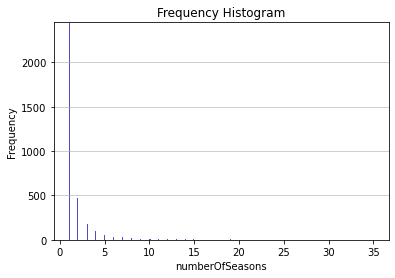

In [15]:
"""
8: Write a query that finds the number of seasons for each TV series. Using the results of the query create a histogram (frequency plot).
"""
#Query
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
con = con_db.cursor()
con.execute('''
    select parenttconst, COUNT(DISTINCT seasonNumber) as numberOfSeasons
    FROM title_episode
    GROUP BY parenttconst
''')
results = con.fetchall()
#print(results)
#Frequency Histogram
numberOfSeasons = []
for i in range(len(results)):
    numberOfSeasons.append(results[i][1])    
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=numberOfSeasons, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('numberOfSeasons')
plt.ylabel('Frequency')
plt.title('Frequency Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
con.close()

In [16]:
# Build a function in your code or a stored procedure in the database (approach is your choice) called addActor() that adds a new actor to the database: this requires updating several tables, so the insertions must occur within a transaction in order to function properly in a concurrent environment. Test your function by inserting a new actor -- you may make up a name and associated information. Show evidence  in your notebook that the actor was properly inserted.

def addActor(primaryName, birthYear, deathYear, primaryProfession):
    con = con_db.cursor()
    # insert into "name_basics" table
    query1 = """
            INSERT OR IGNORE INTO name_basics (nconst, primaryName, birthYear, deathYear)
            VALUES (?,?,?,?) 
            """
    # concate nconst id
    nconst_max = con.execute("SELECT MAX(nconst) FROM name_basics").fetchall()
    nconst_new = nconst_max[0][0][0:2] + str(int(nconst_max[0][0][2:])+1).zfill(7)
    data = (nconst_new, primaryName, birthYear, deathYear)
    con.execute(query1 , data)
    print(pd.read_sql_query("SELECT * FROM name_basics LIMIT 100", con_db))
    # insert into "profession" table
    query2 = """
            INSERT OR IGNORE INTO profession (name)
            VALUES (?) 
            """
    profession_list = primaryProfession.split(",")
    for profession in profession_list:
        con.execute(query2 , tuple([profession]))
    print(pd.read_sql_query("SELECT * FROM profession LIMIT 100", con_db))
    # insert into "name_profession" table
    query3 = """
        INSERT OR IGNORE INTO name_profession (nconst, name)
        VALUES (?,?) 
        """
    for profession in profession_list:
       con.execute(query3, tuple([nconst_new, profession]))
    print(pd.read_sql_query("SELECT * FROM name_profession LIMIT 100", con_db))
    con.close()
addActor("Cecilia Li","1998/08/20","", "actor")

       nconst        primaryName birthYear deathYear   age  numberOfMovies
0   nm0000001       Fred Astaire      1899      1987  88.0             NaN
1   nm0000002      Lauren Bacall      1924      2014  90.0             NaN
2   nm0000003    Brigitte Bardot      1934        \N  86.0             NaN
3   nm0000004       John Belushi      1949      1982  33.0             NaN
4   nm0000005     Ingmar Bergman      1918      2007  89.0             NaN
..        ...                ...       ...       ...   ...             ...
95  nm0000096   Gillian Anderson      1968        \N  52.0             NaN
96  nm0000097    Pamela Anderson      1967        \N  53.0             NaN
97  nm0000098   Jennifer Aniston      1969        \N  51.0             NaN
98  nm0000099  Patricia Arquette      1968        \N  52.0             NaN
99  nm0000100     Rowan Atkinson      1955        \N  65.0             NaN

[100 rows x 6 columns]
                         name
0              visual_effects
1               

In [17]:
# Checking if the actor we just inserted is in place, with age updated. Number of Movies was not updated because the actor hasn't participated in any movie yet.
print(pd.read_sql_query("SELECT * FROM name_basics WHERE primaryName = 'Cecilia Li'", con_db))

      nconst primaryName   birthYear deathYear  age numberOfMovies
0  nm0052305  Cecilia Li  1998/08/20             22           None


In [18]:
#  Build a function in your code or a stored procedure in the database (approach is your choice) called deleteActor() that removes an actor from the database: this requires updating several tables, so the deletions must occur within a transaction in order to function properly in a concurrent environment. Test your function by deleting a new actor inserted in (9) -- show evidence that the removal was successful.

def deleteActor(primaryName, birthYear, deathYear):
    con = con_db.cursor()
    # delete from name_basics
    data = (primaryName,birthYear, deathYear)
    nconst =  con.execute("SELECT nconst FROM name_basics WHERE primaryName = ? AND birthYear = ? AND deathYear = ?", data).fetchone()
    delete_name_basics = "DELETE FROM name_basics WHERE nconst = ? ;"
    con.execute(delete_name_basics, tuple(nconst))
    print(pd.read_sql_query("SELECT * FROM name_basics LIMIT 100", con_db))
    
    # # delete from name_profession
    delete_name_profession = "DELETE FROM name_profession WHERE nconst = ?;"
    con.execute(delete_name_profession, tuple(nconst))
    print(pd.read_sql_query("SELECT * FROM name_profession LIMIT 100", con_db))
    con.close()

deleteActor("Cecilia Li","1998/08/20", "")

       nconst        primaryName birthYear deathYear   age  numberOfMovies
0   nm0000001       Fred Astaire      1899      1987  88.0             NaN
1   nm0000002      Lauren Bacall      1924      2014  90.0             NaN
2   nm0000003    Brigitte Bardot      1934        \N  86.0             NaN
3   nm0000004       John Belushi      1949      1982  33.0             NaN
4   nm0000005     Ingmar Bergman      1918      2007  89.0             NaN
..        ...                ...       ...       ...   ...             ...
95  nm0000096   Gillian Anderson      1968        \N  52.0             NaN
96  nm0000097    Pamela Anderson      1967        \N  53.0             NaN
97  nm0000098   Jennifer Aniston      1969        \N  51.0             NaN
98  nm0000099  Patricia Arquette      1968        \N  52.0             NaN
99  nm0000100     Rowan Atkinson      1955        \N  65.0             NaN

[100 rows x 6 columns]
       nconst              name
0   nm0000001        soundtrack
1   nm000000

In [19]:
# Checking if the actor was successfully removed.
print(pd.read_sql_query("SELECT * FROM name_basics WHERE primaryName = 'Cecilia Li'", con_db))

Empty DataFrame
Columns: [nconst, primaryName, birthYear, deathYear, age, numberOfMovies]
Index: []


In [20]:
"""
11: Write a query to retrieve the names and ages of all actors who appeared in more than two movies (ignore TV movies) 
    which an above average rating.
"""

con = con_db.cursor()
con.execute('''
                SELECT primaryName, age FROM
                                    (
                                    SELECT primaryName, age, title_principals.tconst FROM name_basics
                                    INNER JOIN title_principals ON name_basics.nconst = title_principals.nconst
                                    INNER JOIN title_ratings ON title_principals.tconst = title_ratings.tconst
                                    WHERE (title_principals.category = 'actor' OR title_principals.category = 'actress') AND title_ratings.averageRating > (SELECT AVG(averageRating) FROM title_ratings)
                                    )
                                    GROUP BY primaryName HAVING COUNT(primaryName) > 1;
            ''')
print(con.fetchall())
con.close()

[('Albert Austin', 71), ('Asta Nielsen', 91), ('Bernd Aldor', 69), ('Billy Armstrong', 33), ('Buster Keaton', 71), ('Cecile Arnold', 40), ('Charles Arling', 42), ('Charles Avery', 53), ('Charles Chaplin', 88), ('Claire Anderson', 69), ('D.W. Griffith', 73), ('Douglas Fairbanks', 56), ('Edwin August', 81), ('Fernande Albany', 77), ('Gerald Ames', 52), ('Gertrude Bambrick', 81), ("Gilbert M. 'Broncho Billy' Anderson", 91), ('Hank Mann', 84), ('Harry Carey', 69), ('Henry Ainley', 66), ('John Barrymore', 60), ('John G. Adolfi', 52), ('King Baggot', 69), ('Lillian Gish', 100), ('Linda Arvidson', 65), ('Lionel Barrymore', 76), ('Lloyd Bacon', 66), ('Mary Alden', 63), ('Maurice Costello', 73), ('Olga Baclanova', 81), ('Oliver Hardy', 65), ('Pedro de Cordoba', 69), ('Phyllis Allen', 77), ("Roscoe 'Fatty' Arbuckle", 46), ('Spottiswoode Aitken', 66), ('Theda Bara', 70), ('William Bailey', 76)]


In [21]:
"""
12: Write a query that finds an actor by name (pick a name). Measure the execution time of the query. 
    Then create an index that would improve the performance of the query and then run and measure it again. 
    Show the difference and comment on why that's the case.
"""
import time

con = con_db.cursor()

con.execute('''
            DROP INDEX IF EXISTS name_idx;
            ''')

print("--- Running without index ---")

start_time = time.time()

print(pd.read_sql_query("SELECT * FROM name_basics WHERE primaryName = 'D.W. Griffith'", con_db))

print("--- %s seconds ---" % (time.time() - start_time))

con.execute('''
            CREATE INDEX IF NOT EXISTS name_idx 
            ON name_basics(primaryName);
            ''')

print("\n--- Running with index ---")

start_time = time.time()

print(pd.read_sql_query("SELECT * FROM name_basics WHERE primaryName = 'D.W. Griffith'", con_db))

print("--- %s seconds ---" % (time.time() - start_time))

con.close()

--- Running without index ---
      nconst    primaryName birthYear deathYear  age  numberOfMovies
0  nm0000428  D.W. Griffith      1875      1948   73             547
--- 0.0089569091796875 seconds ---

--- Running with index ---
      nconst    primaryName birthYear deathYear  age  numberOfMovies
0  nm0000428  D.W. Griffith      1875      1948   73             547
--- 0.003020048141479492 seconds ---
